In [1]:
import os
import torch
import json
from torch.utils.data import DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from data import load_data
import matplotlib.pyplot as plt
import seaborn as sns
from util import cross_entropy_loss_fn, plot_samples, compute_nlls, OOD_detection, get_epsilon, sample_model, compute_KID, extract_features, preprocess_samples
import numpy as np
from precision_recall import prd_score
import torchvision.models as models
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_dir_vanilla = 'results_made/20240718_203150_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.0_PAT10_MOD'
result_dir_reg = 'results_made/20240718_210453_S42_E50_BS64_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM0.1_PAT10_MOD'
result_dir_reg_plus = 'results_made/20240718_171224_S42_E50_BS256_LR1e-03_NM1_HL8000_ID784_mnist_BIN_LAM1.0_PAT10_MOD'

model_vanilla = torch.load(result_dir_vanilla + '/model_best.model', map_location=torch.device('cpu')).to(device)
model_vanilla.eval()
model_reg = torch.load(result_dir_reg + '/model_best.model', map_location=torch.device('cpu')).to(device)
model_reg.eval()
model_reg_plus = torch.load(result_dir_reg_plus + '/model_best.model', map_location=torch.device('cpu')).to(device)
model_reg_plus.eval()

MADE(
  (_net): Sequential(
    (0): MaskedLinear(in_features=784, out_features=8000, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=8000, out_features=784, bias=True)
  )
)

# Samples

In [ ]:
# Collect the images and their NLL values
image_nll_pairs = []

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

for i, (x, _) in enumerate(test_loader):
    preds_vanilla = model_vanilla.forward(x)
    preds_reg = model_reg.forward(x)
    preds_reg_plus = model_reg_plus.forward(x)
    nll_vanilla = cross_entropy_loss_fn(x, preds_vanilla)
    nll_reg = cross_entropy_loss_fn(x, preds_reg)
    nll_reg_plus = cross_entropy_loss_fn(x, preds_reg_plus)
    
    image_nll_pairs.append((x.detach().numpy().reshape(28, 28), nll_vanilla.item(), nll_reg.item(), nll_reg_plus.item()))

    if i >= 99:  # Stop after collecting 100 images
        break

# Sort the images by nll_vanilla values
image_nll_pairs.sort(key=lambda pair: pair[1])

# Plot the sorted images
fig1, axes1 = plt.subplots(10, 10, figsize=(10, 10))

for i, (img, nll_vanilla, nll_reg, nll_reg_plus) in enumerate(image_nll_pairs):
    ax = axes1[i // 10, i % 10]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"({round(nll_vanilla)},{round(nll_reg)},{round(nll_reg_plus)})")
    ax.axis('off')

fig1.tight_layout()
plt.show()


# Sample Quality (KID/FID/Precision/Recall)

### KID

In [17]:
from util import sample_model, preprocess_samples
num_samples = 1000
subset_size = 100

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

samples_vanilla = sample_model(model = model_vanilla, n = num_samples, model_type = model_type)

_, _, test_data = load_data('mnist', data_dir = './data', binarize=True, eval = True, val = False)
test_loader = DataLoader(test_data, batch_size=num_samples, shuffle = True)
true = next(iter(test_loader))[0].to(device)

samples_vanilla = sample_model(model = model_vanilla, n = num_samples, model_type = model_type)
samples_vanilla = preprocess_samples(samples_vanilla, preprocess)

kid_mean_vanilla, kid_std_vanilla = compute_KID(true, samples_vanilla, subset_size = subset_size
                                                , device = device, feature = 2048)

print(kid_mean_vanilla, kid_std_vanilla)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


0.00018655062012840062 0.018231265246868134


### Precision and Recall

In [ ]:
# Load pre-trained Inception model
inception_model = models.inception_v3(pretrained=True)
inception_model.eval()  # Set the model to evaluation mode
inception_model.fc = torch.nn.Identity() 

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

model_type = 'MADE'
num_samples = 1000
_, _, test_data = load_data('mnist', data_dir = './data', binarize=True, val = False, eval = True)
test_loader = DataLoader(test_data, batch_size=num_samples, shuffle = True)
true = next(iter(test_loader))[0].to(device)
real_features = extract_features(true, inception_model)

samples_vanilla = sample_model(model = model_vanilla, n = num_samples, model_type = model_type)
samples_vanilla = preprocess_samples(samples_vanilla, preprocess)
generated_features_vanilla = extract_features(samples_vanilla, inception_model)

samples_reg = sample_model(model = model_reg, n = num_samples, model_type = model_type)
samples_reg = preprocess_samples(samples_vanilla, preprocess)
generated_features_reg = extract_features(samples_reg, inception_model)

samples_reg_plus = sample_model(model = model_reg_plus, n = num_samples, model_type = model_type)
samples_reg_plus = preprocess_samples(samples_vanilla, preprocess)
generated_features_reg_plus = extract_features(samples_reg_plus, inception_model)

prd_data_vanilla = prd_score.compute_prd_from_embedding(real_features, generated_features_vanilla)
prd_data_reg = prd_score.compute_prd_from_embedding(real_features, generated_features_reg)
prd_data_reg_plus = prd_score.compute_prd_from_embedding(real_features, generated_features_reg_plus)

In [ ]:
auc_vanilla = np.trapz(prd_data_vanilla[1], prd_data_vanilla[0])
auc_reg = np.trapz(prd_data_reg[1], prd_data_reg[0])
auc_reg_plus = np.trapz(prd_data_reg_plus[1], prd_data_reg_plus[0])
prd_score.plot([prd_data_vanilla, prd_data_reg, prd_data_reg_plus], ['Vanilla', 'Reg', 'Reg Plus'])

0.8179332613452328 0.8290098622629063


# OOD Detection

### ROC/AUC

In [ ]:
from util import roc_pc

batch_size = 1
_, _, test_data = load_data('mnist', './data', binarize=True, val = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
_, _, test_data_emnist = load_data('emnist', './data', binarize=True, val = True)
test_loader_emnist = DataLoader(test_data_emnist, batch_size=batch_size, shuffle=False)

fpr_vanilla, tpr_vanilla, thresholds_vanilla, roc_auc_vanilla, precision_vanilla, \
recall_vanilla, pr_thresholds_vanilla, pr_auc_vanilla, nll_mnist_vanilla, nll_emnist_vanilla \
                                     = roc_pc(test_loader, test_loader_emnist, 
                                                               model_vanilla)

fpr_reg, tpr_reg, thresholds_reg, roc_auc_reg, precision_reg, \
recall_reg, pr_thresholds_reg, pr_auc_reg, nll_mnist_reg, nll_emnist_reg \
                                = roc_pc(test_loader, test_loader_emnist, 
                                                               model_reg)

fpr_reg_plus, tpr_reg_plus, thresholds_reg_plus, roc_auc_reg_plus, precision_reg_plus, \
recall_reg_plus, pr_thresholds_reg_plus, pr_auc_reg_plus, nll_mnist_reg_plus, nll_emnist_reg_plus \
                                    = roc_pc(test_loader, test_loader_emnist, 
                                                               model_reg_plus)

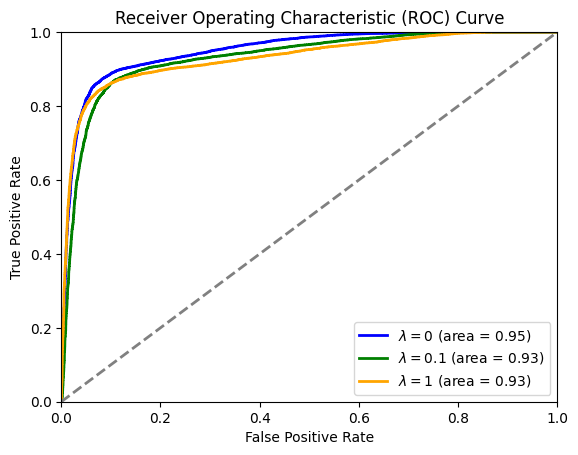

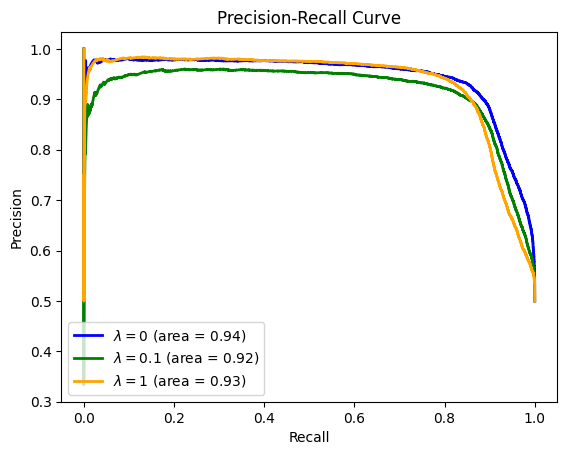

In [60]:
plt.figure()
plt.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'$\lambda = 0$ (area = {roc_auc_vanilla:.2f})')
plt.plot(fpr_reg, tpr_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {roc_auc_reg:.2f})')
plt.plot(fpr_reg_plus, tpr_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {roc_auc_reg_plus:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall_vanilla, precision_vanilla, color='blue', lw=2, label=f'$\lambda = 0$ (area = {pr_auc_vanilla:.2f})')
plt.plot(recall_reg, precision_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {pr_auc_reg:.2f})')
plt.plot(recall_reg_plus, precision_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {pr_auc_reg_plus:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Typicality Test

In [20]:
#https://github.com/simonwestberg/Glow
from util import typicality_test
train_data, val_data, test_data = load_data('mnist', './data', binarize=True, val = True)
_, _, test_data_emnist = load_data('emnist', './data', binarize=True, val = True)
ood_mnist, ood_emnist = typicality_test(model_vanilla, train_data, val_data, test_data, test_data_emnist, K = 1, alpha = 0.95, M_init = 2)

### Visualization

In [16]:
_, _, test_data_emnist = load_data('emnist', './data', binarize=True, val = True)
_, _, test_data_fashion = load_data('fashion', './data', binarize=True, val = True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
test_loader_emnist = DataLoader(test_data_emnist, batch_size=1, shuffle=False)
test_loader_fashion = DataLoader(test_data_fashion, batch_size=1, shuffle=False)

for i , ()

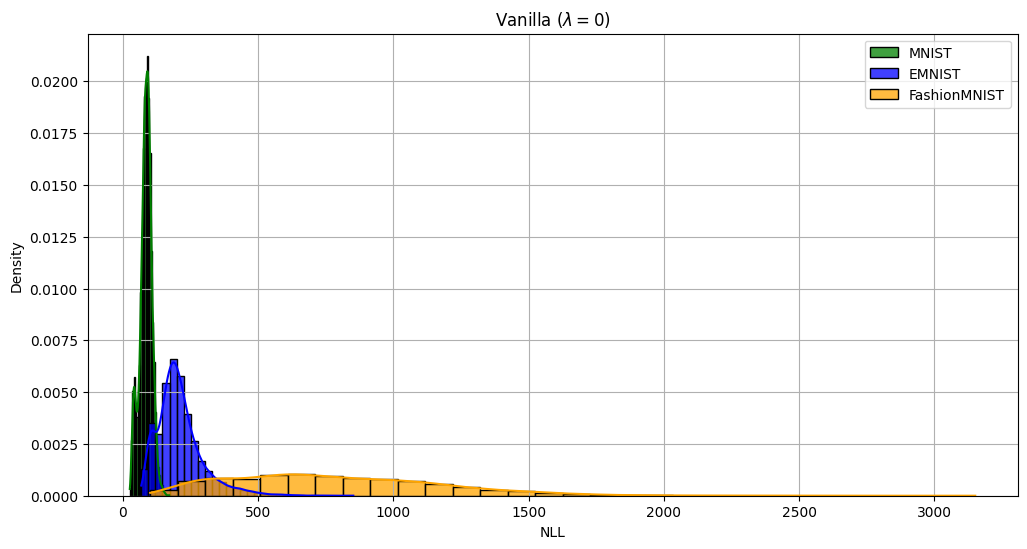

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(np.array(test_lls_mnist_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs, label='MNIST')
sns.histplot(np.array(test_lls_emnist_vanilla), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='EMNIST')
sns.histplot(np.array(test_lls_fashion_vanilla), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs, label='FashionMNIST')
axs.set_title('Vanilla ($\lambda = 0$)')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)

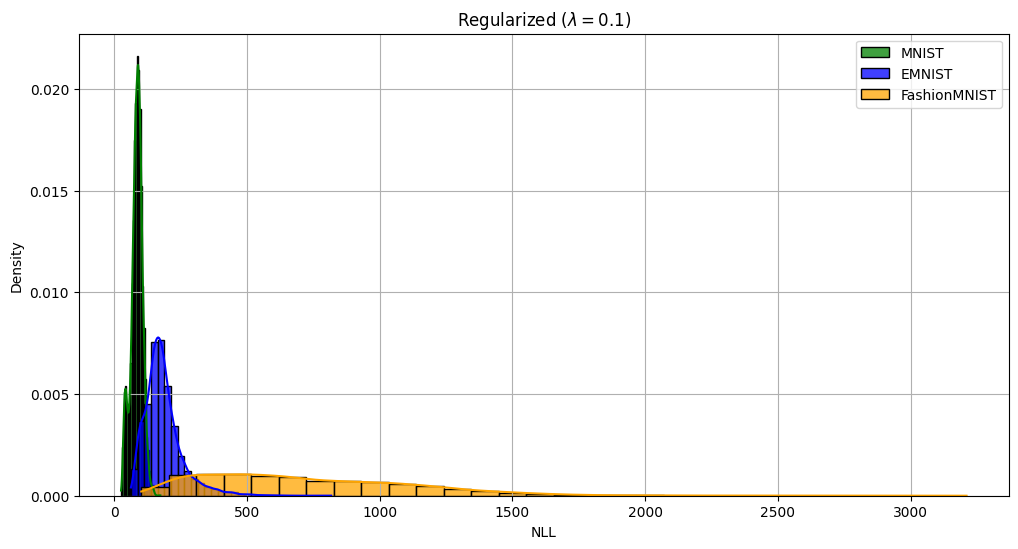

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(np.array(test_lls_mnist_reg), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs, label='MNIST')
sns.histplot(np.array(test_lls_emnist_reg), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='EMNIST')
sns.histplot(np.array(test_lls_fashion_reg), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs, label='FashionMNIST')

axs.set_title('Regularized ($\lambda = 0.1$)')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)

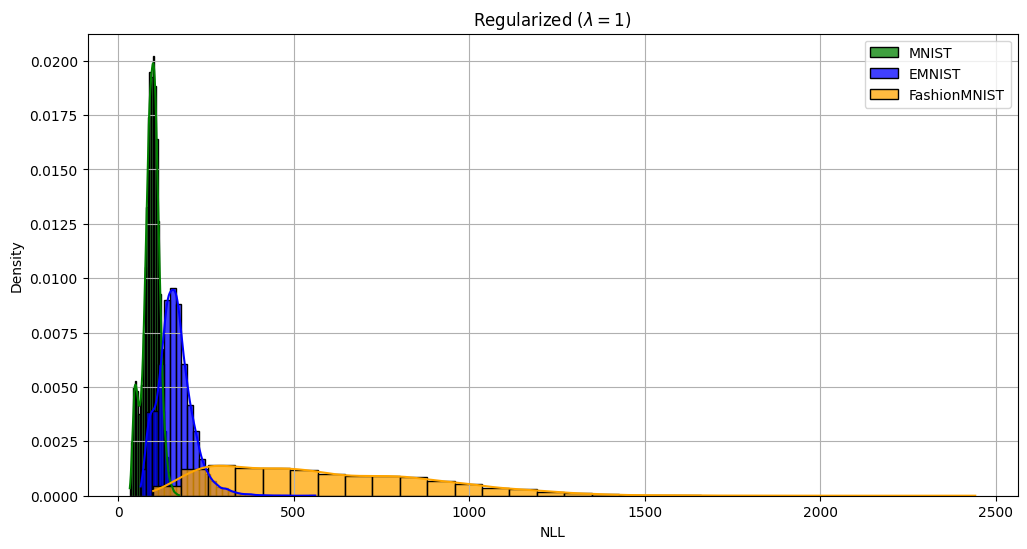

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(np.array(test_lls_mnist_reg_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs, label='MNIST')
sns.histplot(np.array(test_lls_emnist_reg_plus), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='EMNIST')
sns.histplot(np.array(test_lls_fashion_reg_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs, label='FashionMNIST')

axs.set_title('Regularized ($\lambda = 1$)')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)